# Homework 2 (HW2)

---
By the end of this homework we expect you to be able to:
1. Preprocess data and make it amenable to statistical analysis and machine learning models;
2. Train and test out-of-the-box machine learning models in Python;
3. Carry out statistical hypothesis testing;
4. Carry out simple multivariate regression analyses;
5. Use techniques to control for covariates;

---

## Important Dates

- Homework release: Fri 12 Nov 2021
- **Homework due**: Fri 26 Nov 2021, 23:59
- Grade release: Fri 03 Dec 2021

---

##  Some rules

1. You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library,
you may do so, but must justify your choice.
2. Make sure you use the `data` folder provided in the repository in read-only mode. (Or alternatively, be sure you
don’t change any of the files.)
3. Be sure to provide a textual description of your thought process, the assumptions you made, the solution you
implemented, and explanations for your answers. A notebook that only has code cells will not suffice.
4. For questions containing the **/Discuss:/** prefix, answer not with code, but with a textual explanation
 (**in markdown**).
5. Back up any hypotheses and claims with data, since this is an important aspect of the course.
6. Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a
single notebook (plus the required data files) in the *master/main* branch. If there are multiple notebooks present,
we will **not grade** anything.
7. We will **not run your notebook for you**! Rather, we will grade it as is, which means that only the results
contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells.
Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.
8. In continuation to the previous point, interactive plots, such as those generated using `plotly`, should be **strictly avoided**!
9. Make sure to print results or dataframes that confirm you have properly addressed the task.

---

## Context

Congratulations! You have just been hired as a data scientist at *Piccardi Music,* a promising new music label created by a mysterious Italian disc jockey "*Signor Piccardi*". The company hired you to carry out a variety of data-related tasks, which will be explained in further detail below.

---

## The data

For this homework you will use a dataset of 18,403 music reviews scraped from Pitchfork¹, including relevant metadata such as review author, review date, record release year, review score, and genre, along with the respective album's audio features pulled from Spotify's API. The data consists of the following columns:

| Column   | Description  |
|----------|:-------------|
| `artist`           | The name of the artist who created the album being reviewed. |
| `album`            | The name of the album being reviewed. |
| `recordlabel`      | The name of the record label(s) who published the album. |
| `releaseyear`      | The year that the album was released. |
| `score`            | The score given to the album by the reviewer on a scale of 0.0 to 10.0. |
| `reviewauthor`     | The name of the author who reviewed the album. |
| `genre`            | The genre assigned to the album by Pitchfork. |
| `reviewdate`       | The date that the review was published.  |
| `key` | The estimated overall musical key of the track. Integers map to pitches using standard Pitch Class notation (e.g., 0 = C, 2 = D, and so on) |
| `acousticness` | A confidence measure from 0.0 to 1.0 of whether an album is acoustic. 1.0 represents high confidencethat the album is acoustic. |
| `danceability` | How suitable an album is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 1.0 is most danceable.
| `energy` | A perceptual measure of intensity and activity, from 0.0 to 1.0, where 1.0 represents high energy. Metal is often high energy. |
| `instrumentalness` | Predicts whether an album contains no vocals, from 0.0 to 1.0. The closer to 1.0, the more likely the album contains no vocals. |
| `liveness` | Detects the presence of an audience, from 0.0 to 1.0. Scores greater than 0.8 indicate a strong likelihood the album is live. |
| `loudness` | The overall loudness of the album in decibels (dB). |
| `speechiness` | Measures the presence of spoken words in an album on a scale from 0.0 to 1.0. Scores higher than 0.66 indicate an album made entirely of spoken words, while scores below 0.33 indicate music and other non-speech-like elements. |
| `valence` | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by an album, where values closer to 1.0 indicate more positive sounds. |
| `tempo` | The overall estimated tempo of an album in beats per minute (BPM). |

¹Pinter, Anthony T., et al. "P4KxSpotify: A Dataset of Pitchfork Music Reviews and Spotify Musical Features." Proceedings of the International AAAI Conference on Web and Social Media. Vol. 14. 2020.

In [1]:
import random
import re

# pandas / numpy
import pandas as pd
import numpy as np

pd.set_option("display.precision", 2)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# datetime operations
from datetime import datetime

# ttest and euclidean distance
from scipy.stats import ttest_ind
from scipy.spatial.distance import seuclidean

# linear fit using statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# good ole sklearn
from sklearn.metrics import euclidean_distances, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# displaying markdown strings
from IPython.display import display, Markdown, Latex

## Part 1: Will this album be a hit?

The first project you embark on in your new job is to build a regressor to predict whether an album will be well received or not. According to *Signor Piccardi* (your boss), this algorithm may eventually be helpful in forecasting the success of albums produced by *Piccardi Music*.

## Task 1 (Initial analyses — 10 pts)

As a good data scientist, the first thing you do is to have a good look at the data that was handed to you.

1. Load the data using `pandas`. Identify and remove duplicate reviews, i.e., two reviews with albums by the same band with the same name (keep the first occurrence). Print the number of rows in your dataframe.

2. Plot the distribution of album release years and the average score of albums per year.

3. For numerical columns, calculate the mean, median, minimum value and maximum value. Additionally, plot the distribution for all the numerical columns in a single image (possibly with multiple subplots). Your image should be at most 14 inches wide by 14 inches long.

3. For categorical columns, list how many different values there are in each column. If there are less than 10 distinct values for a category, print them all. For the `genre` column, assign the value `'Other'` for albums where the value is either `'none'` or `NaN`.

5. **Discuss:** This dataset was built with *found data*—i.e., the Pitchfork reviews were not made with the goal of training a machine learning model. Grounded on the previous analyses and in Pitchfork's [Wikipedia page](https://en.wikipedia.org/wiki/Pitchfork_(website)), point **three** (exactly!) ways in which this data may not be representative of music albums in general due to the way the data was collected.

---

### Task 1.1

We will load the dataset, remove duplicated reviews and additionally transform the reviewdate to a datetime for later analysis.

In [2]:
# load pitchfork dataset
pitchfork_df = pd.read_csv("data/pitchfork.csv.gz", on_bad_lines="warn")

In [3]:
# create mask with duplicates, keep="first" -> Mark duplicates as True except for the first occurrence.
pitchfork_duplicated_keepfirst_mask = pitchfork_df.duplicated(
    subset=["artist", "album"], keep="first"
)
# mask for all duplicates
pitchfork_duplicated_mask = pitchfork_df.duplicated(
    subset=["artist", "album"], keep=False
)

# print duplicates
print(
    f"There are {len(pitchfork_df[pitchfork_duplicated_keepfirst_mask])} "
    f"duplicated reviews (out of {len(pitchfork_df)})."
)
print("Example of first three duplicates:")
pitchfork_df[pitchfork_duplicated_mask].sort_values(
    ["artist", "album"]
).iloc[:6]

There are 47 duplicated reviews (out of 16785).
Example of first three duplicates:


,artist,album,reviewauthor,score,releaseyear,reviewdate,recordlabel,genre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
10,American Football,American Football,Ian Cohen,8.6,1999.0,May 21 2014,Polyvinyl,Rock,0.48,0.68,5.22,-9.12,0.03,2.73e-01,3.62e-01,0.14,0.28,123.86
11,American Football,American Football,Ian Cohen,7.7,2016.0,October 26 2016,Polyvinyl,Rock,0.48,0.68,5.22,-9.12,0.03,2.73e-01,3.62e-01,0.14,0.28,123.86
8224,Andrew W.K.,I Get Wet,Ian Cohen,8.6,2002.0,August 31 2012,Century Media,Rock,0.45,0.97,4.92,-3.37,0.05,3.31e-03,3.56e-05,0.29,0.65,153.29
8225,Andrew W.K.,I Get Wet,Ryan Schreiber,0.6,2001.0,July 7 2002,Island,Rock,0.45,0.97,4.92,-3.37,0.05,3.31e-03,3.56e-05,0.29,0.65,153.29
8136,Animal Collective,Campfire Songs,Andy Beta,7.1,2003.0,March 31 2003,Catsup Plate,Experimental,0.25,0.36,3.40,-18.28,0.07,8.19e-01,2.42e-01,0.56,0.10,109.18
8137,Animal Collective,Campfire Songs,Brian Howe,7.2,2010.0,January 14 2010,Paw Tracks,Experimental,0.25,0.36,3.40,-18.28,0.07,8.19e-01,2.42e-01,0.56,0.10,109.18


In [4]:
# remove non-first occurrences
pitchfork_df = pitchfork_df[~pitchfork_duplicated_keepfirst_mask]
print(f"We are left with {len(pitchfork_df)} reviews")

We are left with 16738 reviews


In [5]:
# convert reviewdate
print(f"Before:\n{pitchfork_df.reviewdate.head(5)}")
pitchfork_df.reviewdate = pd.to_datetime(pitchfork_df.reviewdate)
print(f"After:\n{pitchfork_df.reviewdate.head(5)}")

Before:
0    February 18 2009
1    February 13 2005
2      August 19 2004
3        July 17 2003
4       August 3 2018
Name: reviewdate, dtype: object
After:
0   2009-02-18
1   2005-02-13
2   2004-08-19
3   2003-07-17
4   2018-08-03
Name: reviewdate, dtype: datetime64[ns]


In [6]:
pitchfork_df_after_task_1_1 = pitchfork_df.copy()

### Task 1.2

The earliest published album in the dataset is from: 1957
The most recently published album in the dataset is from: 2019


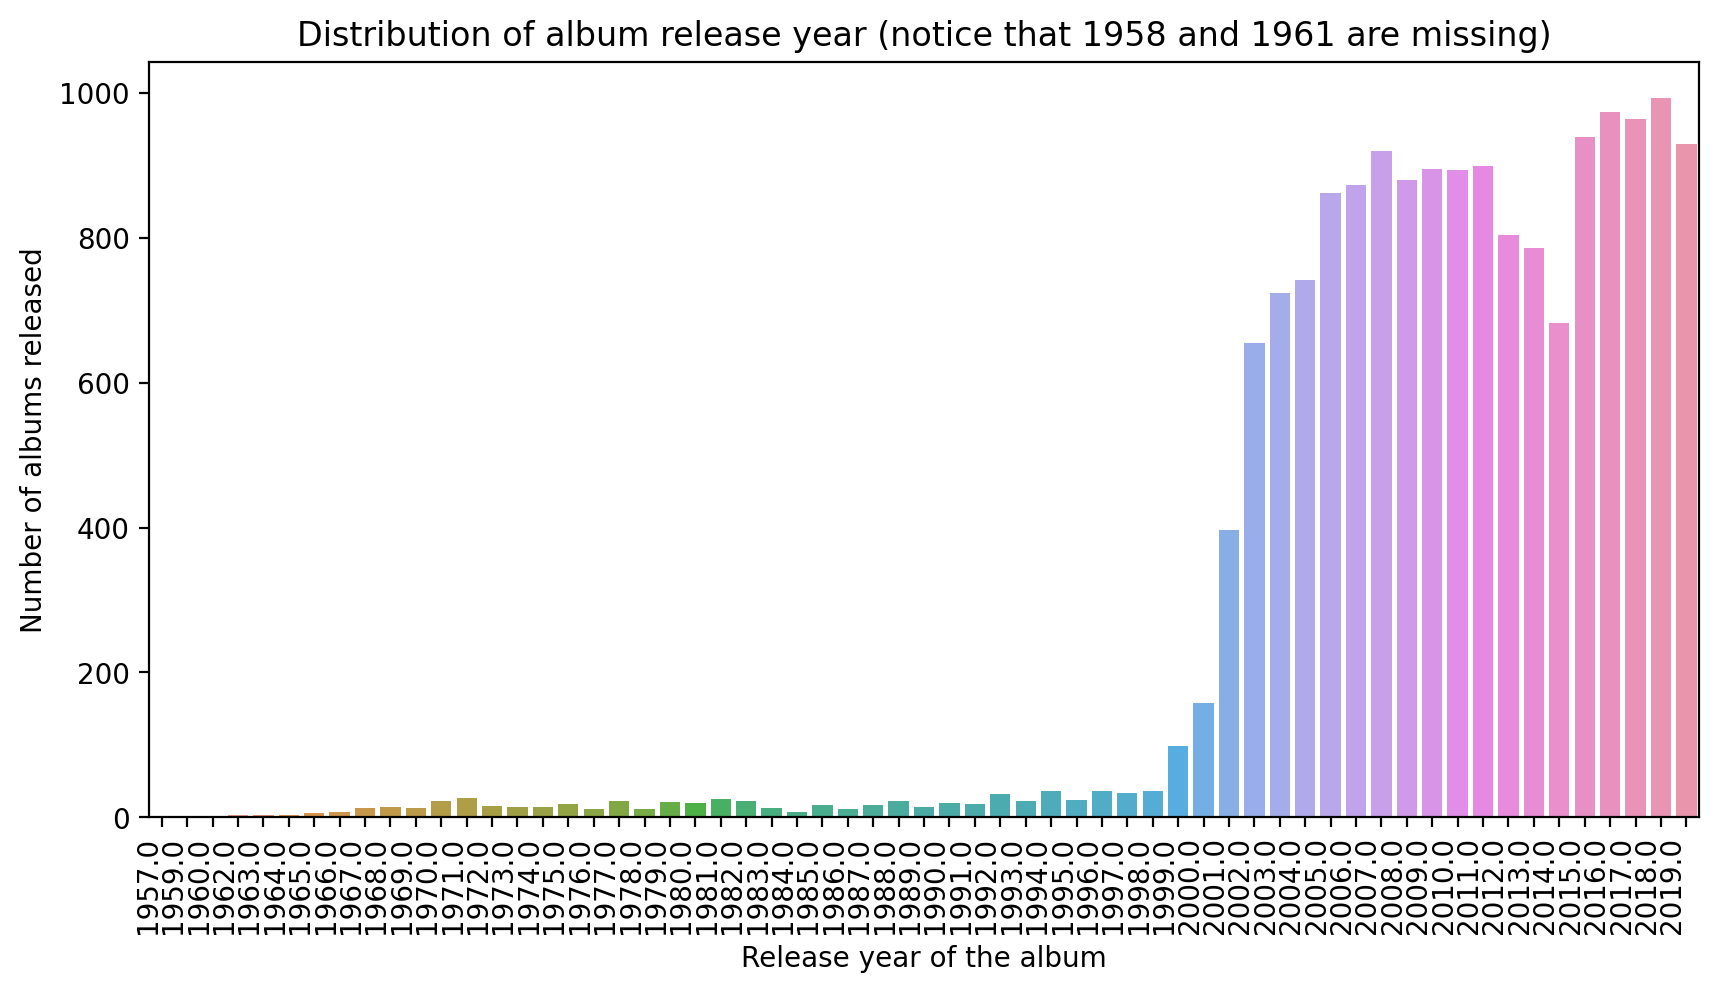

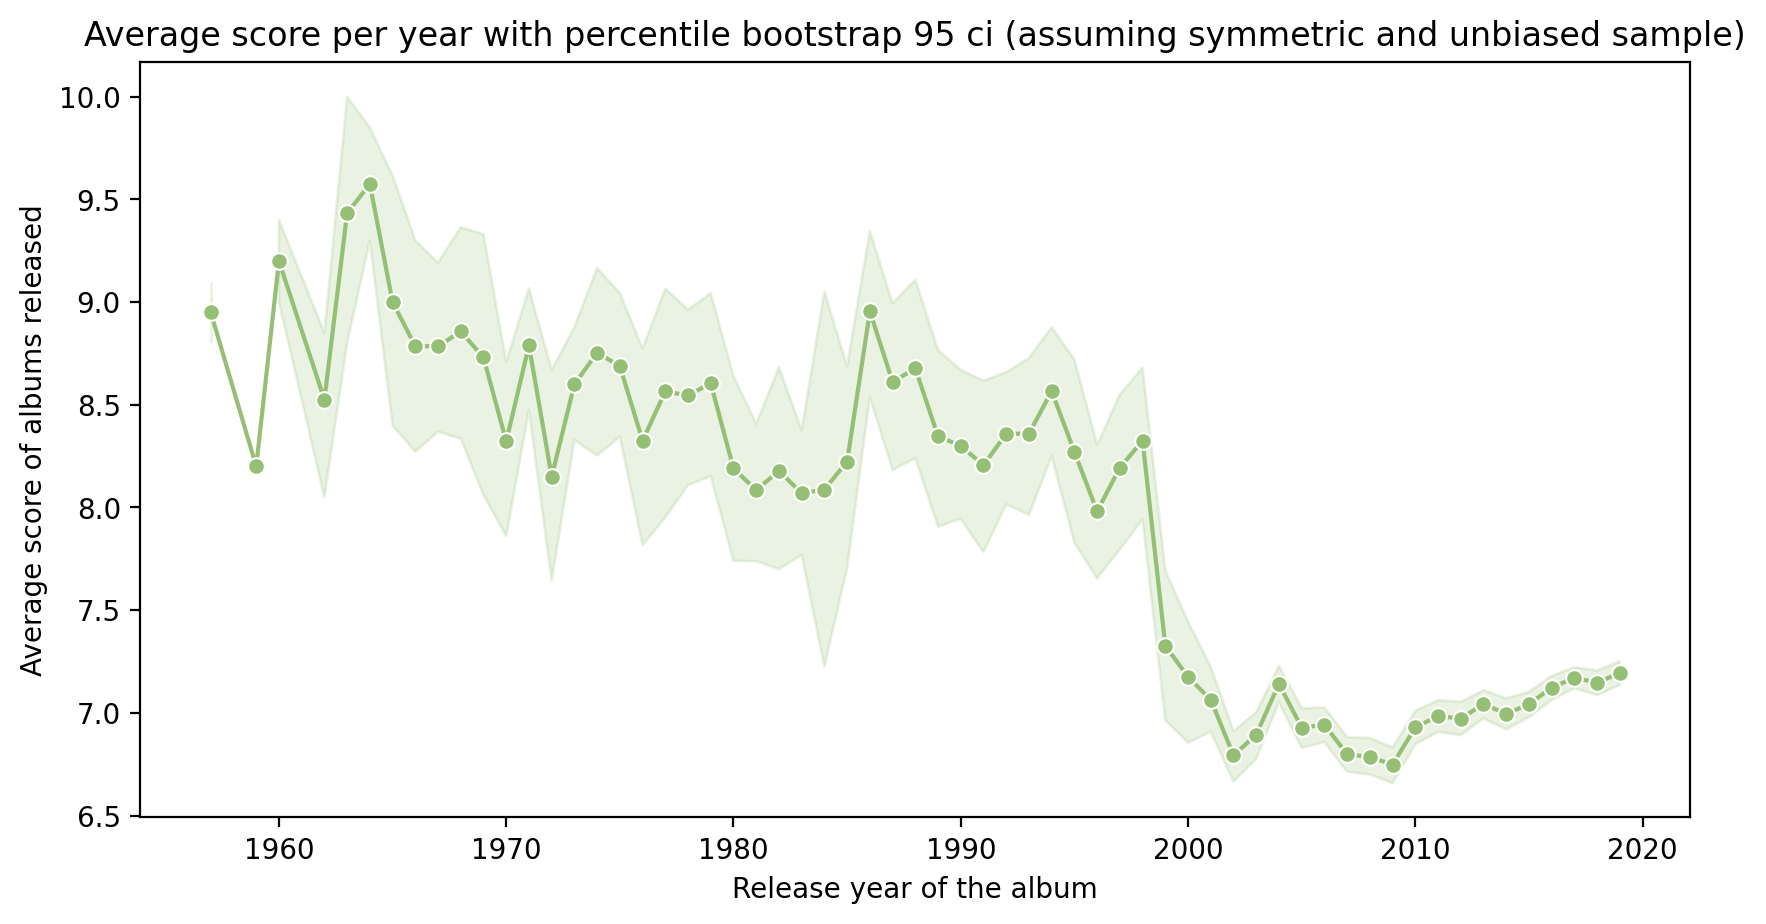

In [7]:
min_year = pitchfork_df.releaseyear.min()
max_year = pitchfork_df.releaseyear.max()
print(f"The earliest published album in the dataset is from: {min_year:.0f}")
print(f"The most recently published album in the dataset is from: {max_year:.0f}")

fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
# num_of_albums_released_per_year = pitchfork_df.groupby("releaseyear").size()
# bins = np.arange(min_year, max_year, max_year-min_year-1)
# sns.histplot(x=pitchfork_df.releaseyear, binwidth=1, ax = ax)
sns.countplot(data=pitchfork_df, x="releaseyear", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title(
    "Distribution of album release year (notice that 1958 and 1961 are missing)"
)
# ax.set_yscale("symlog")
ax.set_xlabel("Release year of the album")
ax.set_ylabel("Number of albums released")
plt.show()

fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
sns.lineplot(
    data=pitchfork_df,
    x="releaseyear",
    y="score",
    estimator="mean",
    ci=95,
    color="#95BF74",
    marker="o",
    ax=ax,
)
ax.set_title(
    "Average score per year with percentile bootstrap 95 ci (assuming symmetric and unbiased sample)"
)
ax.set_xlabel("Release year of the album")
ax.set_ylabel("Average score of albums released")
# ax.grid()
plt.show()

### Task 1.3

In [8]:
pitchfork_df.describe()

,score,releaseyear,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,16738.00,16738.00,16738.00,16738.00,16738.00,16738.00,16738.00,16738.00,1.67e+04,16738.00,16738.00,16738.00
mean,7.05,2009.35,0.51,0.60,5.22,-9.28,0.09,0.30,2.75e-01,0.20,0.41,120.33
std,1.25,7.80,0.16,0.20,1.61,4.24,0.09,0.26,2.99e-01,0.10,0.18,15.48
min,0.00,1957.00,-1.00,-1.00,-1.00,-51.73,-1.00,-1.00,-1.00e+00,-1.00,-1.00,-1.00
25%,6.50,2005.00,0.41,0.47,4.33,-11.22,0.04,0.09,9.60e-03,0.13,0.27,111.24
50%,7.30,2010.00,0.51,0.62,5.23,-8.44,0.06,0.23,1.49e-01,0.17,0.41,120.40
75%,7.80,2015.00,0.62,0.75,6.10,-6.39,0.10,0.46,4.97e-01,0.23,0.53,129.14
max,10.00,2019.00,0.97,1.00,11.00,4.08,0.96,1.00,9.82e-01,0.98,0.97,215.97


Observe the presence of outliers that attain impossible negative values for certain columns:

In [9]:
impossible_rows = (
        (pitchfork_df.danceability < 0)
        | (pitchfork_df.energy < 0)
        | (pitchfork_df.key < 0)
        | (pitchfork_df.speechiness < 0)
        | (pitchfork_df.acousticness < 0)
        | (pitchfork_df.instrumentalness < 0)
        | (pitchfork_df.liveness < 0)
        | (pitchfork_df.valence < 0)
        | (pitchfork_df.tempo < 0)
)

pitchfork_df[impossible_rows]

,artist,album,reviewauthor,score,releaseyear,reviewdate,recordlabel,genre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
607,Patrick Cleandenim,Baby Comes Home,Eric Harvey,6.9,2007.0,2007-08-14,Ba Da Bing!,Pop/R&B,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
722,Missy Elliott,Respect M.E.,Jess Harvell,9.2,2006.0,2006-09-20,Atlantic,Rap,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
2236,Babe Rainbow,Falling Apart,Jonah Bromwich,6.5,2014.0,2014-07-09,Kinky Beggar,Electronic,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
2980,Ashtar Lavanda,Unsolved Mysteries,Rachel Hahn,7.1,2018.0,2018-02-15,Ultramajic,Electronic,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
6676,Unsane,Blood Run,Brandon Stosuy,5.0,2005.0,2005-08-07,Relapse,Rock,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
11446,Rahim,Ideal Lives,Brian Howe,7.5,2006.0,2006-05-04,Frenchkiss,Rap,0.52,0.53,6.36,-6.31,-0.06,0.01,-0.09,0.08,0.46,120.91
12592,Mount Eerie,Sauna,Jayson Greene,8.1,2015.0,2015-02-04,P.W. Elverum & Sun,Rock,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
12593,Vondelpark,Sauna,Hari Ashurst,7.1,2010.0,2011-03-15,R&S,Electronic,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00


We assume that the values should have been denoted as missing, but have been assigned a $-1.0$ instead, except for Rahim's "Ideal Lives" which might be a spurious outlier. As Bob instructed, we will safely lock them up in a cage and never see them again.

In [10]:
print(f"Number of rows before dropping: {len(pitchfork_df)}")
print(f"Number of rows to drop: {impossible_rows.sum()}")
pitchfork_df.drop(pitchfork_df[impossible_rows].index, inplace=True)
print(f"Number of rows after dropping: {len(pitchfork_df)}")

Number of rows before dropping: 16738
Number of rows to drop: 8
Number of rows after dropping: 16730


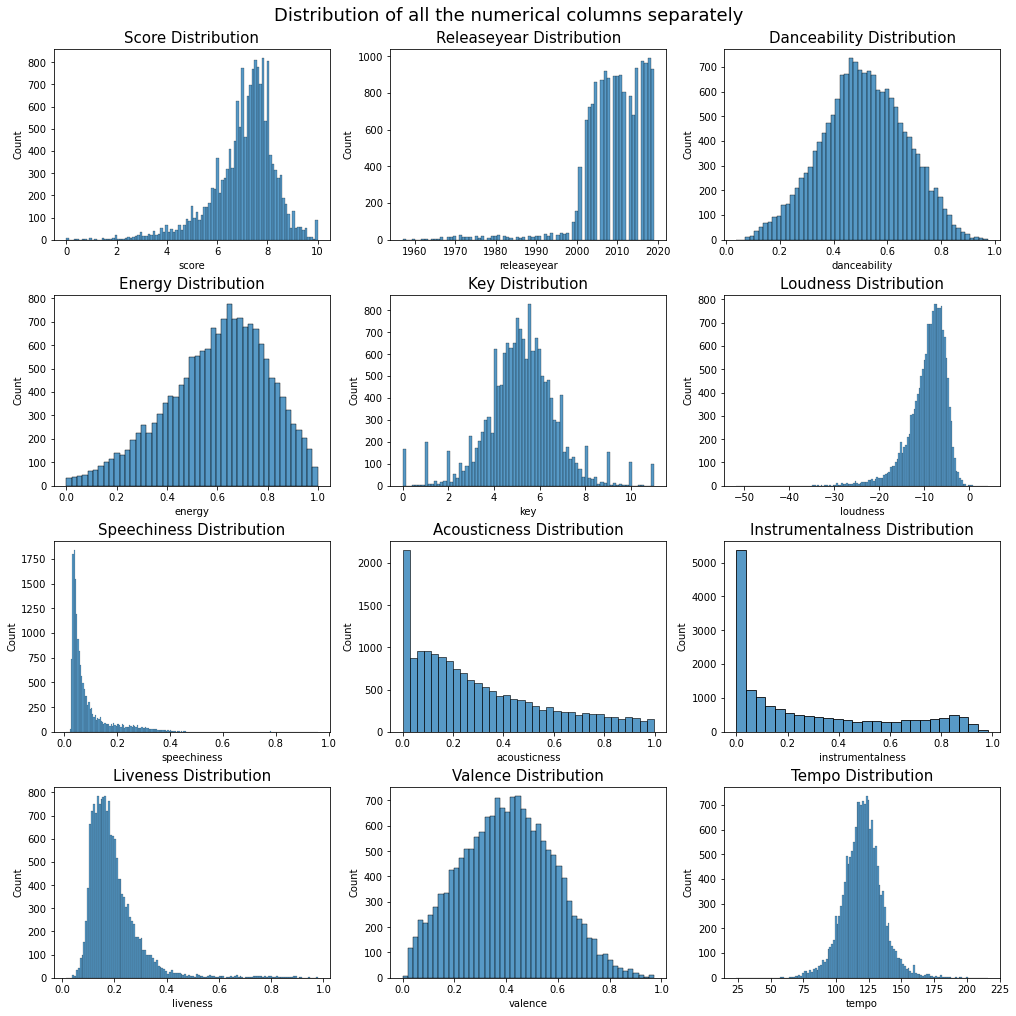

In [11]:
row_num = 4
col_num = 3
fig, axs = plt.subplots(row_num, col_num, constrained_layout=True, figsize=(14, 14))
fig.suptitle("Distribution of all the numerical columns separately", fontsize=18)
numeric_columns_names = pitchfork_df.select_dtypes(include=np.number).columns.to_list()
assert len(numeric_columns_names) == row_num * col_num

for index, column_name in enumerate(numeric_columns_names):
    ax = axs[index // col_num][index % col_num]
    ax.set_title(f"{column_name} distribution".title(), fontsize=15)
    # ax.set_yscale("symlog")
    sns.histplot(pitchfork_df[column_name], ax=ax)

Additionally, here is the distribution of the review date:

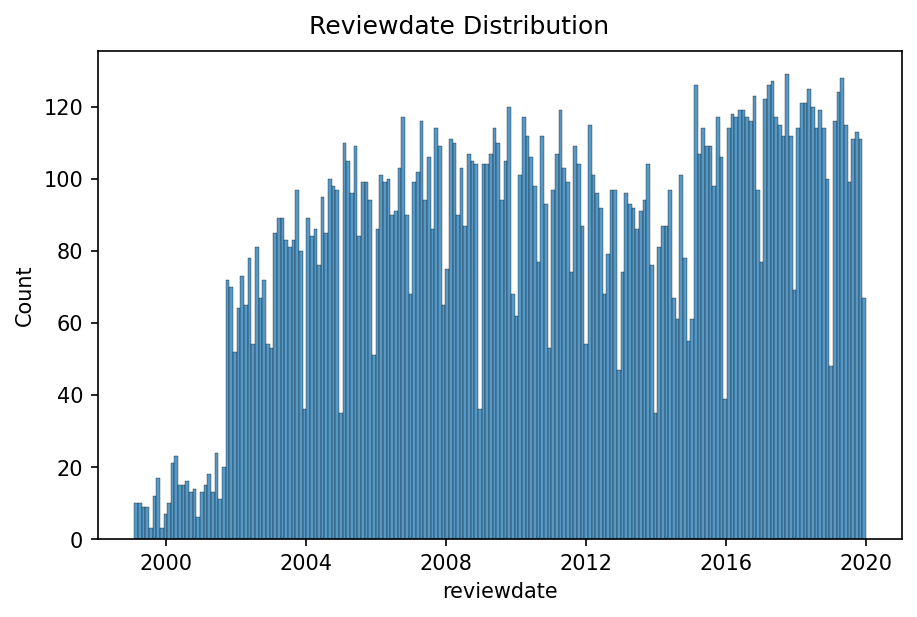

In [12]:
fig, ax = plt.subplots(constrained_layout=True, dpi=150)
fig.suptitle("Reviewdate Distribution")
sns.histplot(pitchfork_df.reviewdate, bins=200, ax=ax)
plt.show()

### Task 1.4

In [13]:
pitchfork_df.loc[
    pitchfork_df.genre.isna() | pitchfork_df.genre.isin(["none"]), "genre"
] = "Other"

In [14]:
categorical_columns_names = pitchfork_df.select_dtypes(
    include=["object"]
).columns.tolist()

for column_name in categorical_columns_names:
    column_unique_values = pitchfork_df[column_name].unique()
    print(
        f"Column name: {column_name}\n  --> number of unique values: {len(column_unique_values)}"
    )

    if len(column_unique_values) <= 10:
        print(f"  --> values: {column_unique_values}")
    print()

Column name: artist
  --> number of unique values: 7890

Column name: album
  --> number of unique values: 16176

Column name: reviewauthor
  --> number of unique values: 554

Column name: recordlabel
  --> number of unique values: 3030

Column name: genre
  --> number of unique values: 10
  --> values: ['Electronic' 'Folk/Country' 'Rock' 'Rap' 'Global' 'Experimental' 'Metal'
 'Pop/R&B' 'Jazz' 'Other']



### Task 1.5

Three ways in which Porkfitch reviews may not be representative of music albums in general:
- independent music scene is overrepresented *(wikipedia)*
- the website has a reputation for publishing reviews early and for being unpredictable, often strongly dependent on which reviewer was writing *(wikipedia)*
- old music (before 2000s) has a mere number of reviews *(analysis above)*

These observations must be noted before training a regression machine learning model that would predict the score of a new song for Signor Piccardi, as the predictions would be highly biased by Pitchfork reviewers taste and choices, rendering their generalization ability (towards other reviewers or the public) useless.

## Task 2 (Pre-processing and pipeline code — 12 pts)

Next, you decide to prepare the code that will help you in training your machine learning models. Also, you implement a simple baseline. For this task, **unless otherwise stated** you must implement functions yourself, instead of relying on `scikit-learn` (you can use `numpy` or `pandas`, though!).

1. For each possible value in the `genre` column, create a new column called `{genre}_onehot` (e.g., for `genre=jazz`, create `jazz_onehot`). Collectively, these new columns should "one hot-encode" the genre column—for instance, if for a given album the `genre` is filled with the value `jazz`, the `jazz_onehot` column should equal 1 and all other `{genre}_onehot` columns should equal 0.

2. Create a function `numpy_helper(df, cols)` to obtain a `numpy.array` out of your `dataframe`. The function should receive a dataframe `df` with N rows and a list of M columns `cols`, and should return a `np.array` of dimension (NxM).

3. For each album, build an array of features `X` containing all genre-related one-hot features, and an array of outcomes `y` containing scores. Using the function [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with `random_state=123`, split the data into a train set containing 70% of all data, and a test set containing the remaining 30%.

4. Create your own baseline regressor. Using the training data (in the training stage), your regressor should estimate the average score for all albums. Then, for the test data (in the prediction stage), your classifier should always output the average score (computed on the training data).

5. Calculate the [coefficient of determination ($R^2$)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) of your baseline on the test data. **You are allowed to use the `sklearn` implementation here.**

6. **Discuss:** Your train-test split randomly selected 70% of all data for the training set. Why is this a problem for the broader task of predicting whether a future album will be successful or not?

---

### Task 2.1

In [15]:
genre_onehot_df = pd.get_dummies(pitchfork_df.genre, )
genre_onehot_df.columns = genre_onehot_df.columns.str.replace("/", "_").str.replace("&",
                                                                                    "_").str.lower() + "_onehot"

genre_onehot_columns = genre_onehot_df.columns.to_list()
print(f"Onehot columns: {genre_onehot_columns}")

Onehot columns: ['electronic_onehot', 'experimental_onehot', 'folk_country_onehot', 'global_onehot', 'jazz_onehot', 'metal_onehot', 'other_onehot', 'pop_r_b_onehot', 'rap_onehot', 'rock_onehot']


In [16]:
pitchfork_df = pitchfork_df.join(genre_onehot_df)
pitchfork_df.head()

,artist,album,reviewauthor,score,releaseyear,reviewdate,recordlabel,genre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,electronic_onehot,experimental_onehot,folk_country_onehot,global_onehot,jazz_onehot,metal_onehot,other_onehot,pop_r_b_onehot,rap_onehot,rock_onehot
0,Studio 1,Studio 1,Andy Battaglia,8.5,2009.0,2009-02-18,Studio,Electronic,0.51,0.50,5.25,-5.63,0.03,7.25e-01,0.02,0.17,0.56,101.40,1,0,0,0,0,0,0,0,0,0
1,John Fahey,The Great Santa Barbara Oil Slick,Mark Richardson,8.2,2005.0,2005-02-13,Water,Folk/Country,0.37,0.33,4.47,-19.15,0.15,6.47e-01,0.56,0.53,0.18,107.62,0,0,1,0,0,0,0,0,0,0
2,Reigning Sound,Too Much Guitar,Stephen M. Deusner,8.3,2004.0,2004-08-19,In the Red,Electronic,0.25,0.91,4.43,-1.09,0.06,2.53e-04,0.75,0.20,0.55,133.90,1,0,0,0,0,0,0,0,0,0
3,The Red Thread,After the Last,Chris Dahlen,7.3,2003.0,2003-07-17,Badman,Rock,0.43,0.43,5.70,-12.87,0.03,3.10e-01,0.22,0.13,0.45,104.35,0,0,0,0,0,0,0,0,0,1
4,Mac Miller,Swimming,Evan Rytlewski,7.5,2018.0,2018-08-03,Warner Bros.,Rap,0.62,0.44,4.15,-9.46,0.17,6.52e-01,0.01,0.12,0.28,122.12,0,0,0,0,0,0,0,0,1,0


### Task 2.2

In [17]:
def numpy_helper(df, cols):
    return df[cols].to_numpy()


numpy_helper(pitchfork_df, ["electronic_onehot", "folk_country_onehot", "rock_onehot"])

array([[1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 1],
       [0, 0, 0]], dtype=uint8)

### Task 2.3

In [18]:
random_state = 123
train_split_ratio = 0.7

task2_X = numpy_helper(pitchfork_df, genre_onehot_columns)
task2_Y = numpy_helper(pitchfork_df, "score")

task2_X_train, task2_X_test, task2_Y_train, task2_Y_test = train_test_split(
    task2_X,
    task2_Y,
    train_size=train_split_ratio,
    random_state=random_state,
)
len(task2_X_test)

5019

### Task 2.4

In [19]:
class BaselineRegression:
    def __init__(self):
        self._average = 0

    def fit(self, x, y):
        self._average = y.mean()

    def predict(self, x):
        return np.full(x.shape[0], self._average)


baseline_regressor = BaselineRegression()
baseline_regressor.fit(task2_X_train, task2_Y_train)
task2_Y_test_pred = baseline_regressor.predict(task2_X_test)

### Task 2.5

In [20]:
print(f"R^2 train score: {r2_score(task2_Y_train, baseline_regressor.predict(task2_Y_train))}")
print(f"R^2 test score: {r2_score(task2_Y_test, task2_Y_test_pred)}")

print("\nNotice the difference between the train/test means:")
print(f"Train y mean: {task2_Y_train.mean()}")
print(f"Test y mean: {task2_Y_test.mean()}")

R^2 train score: 0.0
R^2 test score: -1.0839329994682956e-05

Notice the difference between the train/test means:
Train y mean: 7.049790794979079
Test y mean: 7.04560669456067


A constant model that always predicts the expected value of y, disregarding the input features, would get a $R^2$ score of $0$. Being a bit below $0$ on the test subset, our model is slightly worse than this as it does not know the exact average of the test scores, but estimates it on the train subset.

### Task 2.6

Assuming that the model trained on 70% of data is used directly in production, the main pain-point is that 30% of the data is unused. For better generalization, the model could be retrained on the whole dataset.

Considering the evaluated generalization performance on the test set, we argue that it would make more sense to create a train-test split that would take into account the release year of the album, such that the oldest 70% of albums are put into training and the rest into test, or that time series cross validation is performed. The evaluation would otherwise be optimistic and neglect the distribution shift that will likely occur with time.

## Task 3 (Regression — 14 pts)

Finally, you get down to business and train your regression models.

1. Build a Linear Regression model (use `sklearn`) that predicts the outcome `score` using the features "releaseyear",  "key", "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "valence", "tempo" and the one-hot encoded genre-related columns.  Using a 70/30 train-test split similar to what you did in task two (hereinafter referred to as "the random split", use the same random seed, `random_state=123`), report the $R^2$ for the testing set.

2. Create an alternate train-test split (hereinafter referred to as "the longitudinal split") where you train with data from albums released before 2000 and test with data from 2003 and after. Report the $R^2$ for the testing set using the same model you developed for the previous question. **Discuss:** give the correct interpretation of $R^2$ value for the longitudinal split.

3. For a given entry $X$ your model outputs a predicted score $Y'$. The difference between the real score $Y$ and the predicted score $Y'$ is called the "residual". Considering the model trained in 3.2, plot the distribution of your residuals for the test set. Additionally, estimate what is the probability that your score prediction (from 3.2) is off by more than 2-points? Provide bootstrapped confidence intervals for your answer.

4. Experiment with training a different regressor, a Gradient Boosting Regressor. This regressor is related to the Boosted decision trees that you have seen in class. This model performs extremely well for a variety of tasks and is often used in machine learning competitions for tabular data (e.g., on Kaggle). Train the regressor using the longitudinal split and the same features as in 3.2, use the default hyperparameters. Report the $R^2$ for the testing set.

5. **Discuss:** Hypothesize a reason for the difference in performance between the Linear regression and the Gradient Boosting Regressor.

---

### Task 3.1

In [21]:
features_col_names = [
                         "releaseyear",
                         "key",
                         "acousticness",
                         "danceability",
                         "energy",
                         "instrumentalness",
                         "liveness",
                         "loudness",
                         "speechiness",
                         "valence",
                         "tempo",
                     ] + genre_onehot_columns

task3_X = numpy_helper(pitchfork_df, features_col_names)
task3_Y = numpy_helper(pitchfork_df, "score")

random_state = 123
train_split_ratio = 0.7

task3_X_train, task3_X_test, task3_Y_train, task3_Y_test = train_test_split(
    task3_X,
    task3_Y,
    train_size=train_split_ratio,
    random_state=random_state,
)

linear_regressor = LinearRegression()
linear_regressor.fit(task3_X_train, task3_Y_train)

task3_Y_train_pred = linear_regressor.predict(task3_X_train)
task3_Y_test_pred = linear_regressor.predict(task3_X_test)

print(f"R^2 train score: {r2_score(task3_Y_train, task3_Y_train_pred)}")
print(f"R^2 test score: {r2_score(task3_Y_test, task3_Y_test_pred)}")

R^2 train score: 0.03871243053175011
R^2 test score: 0.038669870192804434


A terrible $R^2$ score, but positive and above the baseline.

### Task 3.2

In [22]:
# train dataset should be before 2000
train_mask = pitchfork_df["releaseyear"] < 2000
test_mask = pitchfork_df["releaseyear"] >= 2003

task3_X_train_alt = numpy_helper(pitchfork_df[train_mask], features_col_names)
task3_Y_train_alt = numpy_helper(pitchfork_df[train_mask], "score")

task3_X_test_alt = numpy_helper(pitchfork_df[test_mask], features_col_names)
task3_Y_test_alt = numpy_helper(pitchfork_df[test_mask], "score")

linear_regressor_alt = LinearRegression()
linear_regressor_alt.fit(task3_X_train_alt, task3_Y_train_alt)

task3_Y_test_pred_alt = linear_regressor_alt.predict(task3_X_test_alt)

print(f"Number of training datapoints: {len(task3_X_train_alt)}")
print(f"Number of test datapoints: {len(task3_X_test_alt)}")
print(f"Mean train score: {task3_Y_train_alt.mean()}")
print(f"Mean test score: {task3_Y_test_alt.mean()}")

print(
    f"\nR^2 train score: {r2_score(task3_Y_train_alt, linear_regressor_alt.predict(task3_X_train_alt))}")
print(f"R^2 test score: {r2_score(task3_Y_test_alt, task3_Y_test_pred_alt)}")

Number of training datapoints: 778
Number of test datapoints: 14744
Mean train score: 8.287017994858612
Mean test score: 6.9927495930548025

R^2 train score: 0.11068529733684196
R^2 test score: -0.28225204260641057


The $R^2$ test score is negative and much worse than a baseline who would know the mean of the test dataset. We would account this primarily to the test set being unrepresented in the small and old train dataset, which is easily noticeable in the difference between the mean train and test scores. The noticeable difference between score distribution for release years before 2000s was already visualized in task 1.2.

### Task 3.3

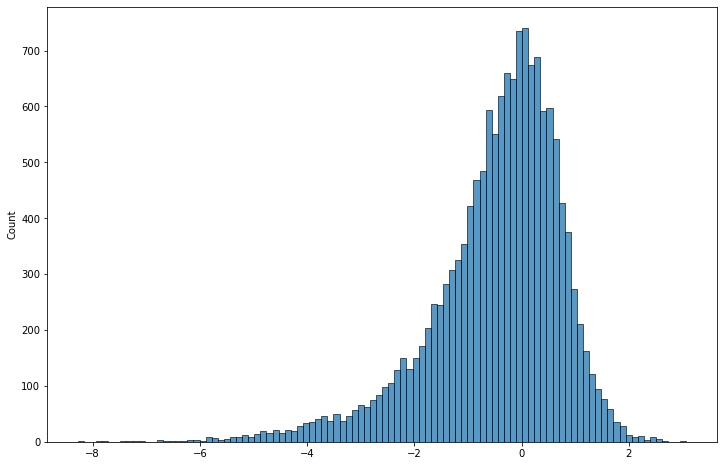

In [23]:
residuals = task3_Y_test_alt - task3_Y_test_pred_alt
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(residuals, ax=ax);

The residual plot is very skewed to the left. This is because our model tends to give a higher score compared to the true score, which is expected since the reviews in the train set have a much higher mean. We will now estimate the probability of the score being off by more than two points (in absolute value).

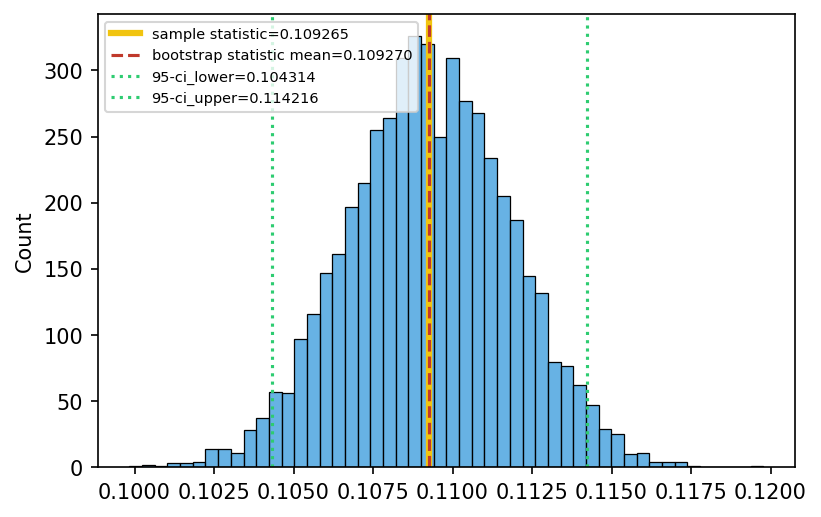

Conficence interval: [0.10431362 0.11421595]


In [24]:
def bootstrap(sample, func, n_boot, seed=None):
    if seed is not None:
        np.random.seed(seed)

    boots = []
    for _ in range(n_boot):
        indices = np.random.randint(0, len(sample), len(sample))
        resample = sample[indices]
        sample_statistic = func(resample)
        boots.append(sample_statistic)

    return np.array(boots)


def percentile_ci(sample, confidence=95, axis=None):
    percentiles = 50 - confidence / 2, 50 + confidence / 2
    return np.nanpercentile(sample, percentiles, axis)


def plot_bootstrap_distribution(sample, boots, ci, confidence, sample_statistic_function):
    fig, ax = plt.subplots(1, 1, dpi=150)
    sample_statistic = sample_statistic_function(sample)
    boots_mean_statistic = boots.mean()
    sns.histplot(boots, color="#3498db", ax=ax)
    plt.axvline(x=sample_statistic, color='#f1c40f', linestyle='-', linewidth=3,
                label=f"sample statistic={sample_statistic:.6f}")
    plt.axvline(x=boots_mean_statistic, color='#c0392b', linestyle='--',
                label=f"bootstrap statistic mean={boots_mean_statistic:.6f}")
    plt.axvline(x=ci[0], color='#2ecc71', linestyle=':', label=f"{confidence}-ci_lower={ci[0]:.6f}")
    plt.axvline(x=ci[1], color='#2ecc71', linestyle=':', label=f"{confidence}-ci_upper={ci[1]:.6f}")
    plt.legend(loc="upper left", fontsize=7)
    plt.show()


def percentile_bootstrap_ci(sample, n_boot, sample_statistic_function, confidence=95, seed=None,
                            plot_boots=False):
    boots = bootstrap(sample, sample_statistic_function, n_boot, seed)
    ci = percentile_ci(boots, confidence)

    if plot_boots:
        plot_bootstrap_distribution(sample, boots, ci, confidence, sample_statistic_function)

    return ci


def off_by_more_than_two_prob(sample):
    return ((sample > 2).sum() + (sample < -2).sum()) / len(sample)


# Compute and plot the percentile method bootstrap confidence intervals
ci = percentile_bootstrap_ci(residuals, 5000, off_by_more_than_two_prob, seed=72, plot_boots=True)
print(f"Conficence interval: {ci}")

The estimated probability of the predicted score being off by more than 2-points on the test set is $11.63\%$, with a $95\%$ confidence interval of $[11.14\%,12.14\%]$. Given that the bootstrap sample statistics are approximately symmetric and since there seems not to be an inherent bias in the sample (given that the sample statistic and mean bootstrap statistic are almost equal), all assumptions for the used percentile method are justified.

### Task 3.4

In [25]:
gradient_boosting_regressor_alt = GradientBoostingRegressor()
gradient_boosting_regressor_alt.fit(task3_X_train_alt, task3_Y_train_alt)

task3_Y_train_pred_gbr_alt = gradient_boosting_regressor_alt.predict(task3_X_train_alt)
task3_Y_test_pred_gbr_alt = gradient_boosting_regressor_alt.predict(task3_X_test_alt)
print(f"R^2 train score: {r2_score(task3_Y_train_alt, task3_Y_train_pred_gbr_alt)}")
print(f"R^2 test score: {r2_score(task3_Y_test_alt, task3_Y_test_pred_gbr_alt)}")

R^2 train score: 0.572939923914475
R^2 test score: -0.3991586034786754


### Task 3.5

The Gradient Boosting Regressor (GBR) outperformed linear regression on the training set ($R^2$ of $0.573$ vs $0.111$), but was worse on the test set ($R^2$ of $-0.362$ vs $-0.280$). We hypothesize that the reason for better train performance is that GBR was more able to fit on the non-representative train dataset compared to the linear regression. GBR is an ensemble model and can model more complex, non-linear relationships given the same input features. We however hypothesize that better fitting the train dataset had negative consequences on predictive power on the out-of-distribution, high-selective-bias test set, which is why the simpler but biased linear regression performed somewhat better.

## Task 4 (Are we solving the correct problem? — 16 pts)

All your efforts so far have assumed that decisions are taken at the "album" level, which is often not the case for bands with multiple albums. In those cases, it could be interesting to predict what is the success of a given band album given the features of the album **and of previous albums**.

1. Create a new dataframe that contains one row per band with more than 1 album. This dataframe should have the same columns as the data provided to you, considering the latest album of the respective band (note that this is determined by the release year of the album, not the date when it was reviewed). Additionally, for each feature considered in Task 3.1 (including the one-hot encoded features), create an additional column post-fixed with `_previous` (e.g., `danceability_previous`). These columns should contain the average values for all of the band's previous albums. Also, create a column `score_previous` with the average score of previous albums. Print the number of rows in the dataframe as well as the name of the columns.

2. Train a Gradient Boosting Regressor considering all features created in Task 4.1 (note that `score` is the outcome and everything else is a feature, including `score_previous`). Use the 70/30 random train-test split, the default hyperparameters, and report the $R^2$ for the testing set.

3. Can hyperparameter tuning improve your model? Write modular code (i.e., a function) to divide your training data into $N$ folds and perform cross-validation. Experiment tuning two hyperparameters of the Gradient Boosting Regressor: `n_estimators` and `learning_rate`. For each possible combination of the two hyperparameters (see below for the range of values that you should try for each hyperparameter), train your model in a cross-validation setup with $N=20$ folds. Report the mean  $R^2$ along with the 90% CI for each scenario.
    - n_estimators $ \in  \{ 100, 200, 300, 400\}$
    - learning_rate $ \in  \{ 0.1, 0.05, 0.01\}$.

 With the best hyperparameters obtained, train your model with the entire training set and report the $R^2$ on the testing set.

4. **Discuss:** How do these results compare with the previous setup (the scenario considered in **Task 3.4**)? Point out two reasons why it is hard to compare the results obtained in 4.3 and 3.4 at face value? How would you fairly compare the two different setups?

---

### Task 4.1

In [26]:
# create the new dataframe

## 1. get the desired artists' names
artists = pitchfork_df.groupby("artist").size()
artists = artists[artists.ge(2)]
print(f"Artists Indices: {artists.index}")

# 2. previous albums
albums = pitchfork_df.loc[pitchfork_df["artist"].isin(artists.index)]
albums = albums.sort_values(["artist", "releaseyear"], ascending=[True, False])
previous_album_mask = albums.duplicated(subset=["artist"], keep="first")

bad = {"artist", "album", "reviewauthor", "releaseyear", "reviewdate", "recordlabel", "genre"}
previous_columns = list(set(albums.columns) - bad)
previous_albums = albums[previous_album_mask].groupby("artist")[previous_columns].mean()
previous_albums.columns = previous_albums.columns.str.replace("_onehot", "") + "_previous"

# 3. latest albums
albums = albums[~previous_album_mask].join(previous_albums, on="artist")
print(f"Number of rows with NaNs: {albums.isna().any(axis=1).sum()}")
albums.head()

Artists Indices: Index(['!!!', '(Sandy) Alex G', '...And You Will Know Us by the Trail of Dead',
       '03 Greedo', '13 & God', '13ghosts', '1990s', '2 Chainz', '21 Savage',
       '2562',
       ...
       'patten', 'serpentwithfeet', 'stellastarr*', 'volcano!', 'xxxy',
       'yMusic', '¡Forward, Russia!', 'µ-Ziq', 'Âme', 'Ólafur Arnalds'],
      dtype='object', name='artist', length=3561)
Number of rows with NaNs: 0


,artist,album,reviewauthor,score,releaseyear,reviewdate,recordlabel,genre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,electronic_onehot,experimental_onehot,folk_country_onehot,global_onehot,jazz_onehot,metal_onehot,other_onehot,pop_r_b_onehot,rap_onehot,rock_onehot,key_previous,score_previous,loudness_previous,folk_country_previous,danceability_previous,energy_previous,electronic_previous,rock_previous,speechiness_previous,acousticness_previous,global_previous,valence_previous,metal_previous,jazz_previous,other_previous,liveness_previous,pop_r_b_previous,experimental_previous,rap_previous,tempo_previous,instrumentalness_previous
16478,!!!,Wallop,Jesse Dorris,7.2,2019.0,2019-09-07,none,Rock,0.75,0.74,5.36,-8.63,0.13,0.10,1.76e-01,0.18,0.53,120.04,0,0,0,0,0,0,0,0,0,1,5.56,6.87,-6.46,0.0,0.70,0.82,0.0,1.0,0.08,0.07,0.0,0.68,0.0,0.0,0.0,0.19,0.0,0.0,0.0,116.10,1.84e-01
16450,(Sandy) Alex G,House of Sugar,Anna Gaca,8.6,2019.0,2019-09-16,none,Rock,0.49,0.64,4.31,-5.60,0.03,0.26,2.89e-01,0.16,0.42,109.09,0,0,0,0,0,0,0,0,0,1,6.07,8.40,-7.04,0.0,0.46,0.59,0.0,1.0,0.05,0.28,0.0,0.46,0.0,0.0,0.0,0.22,0.0,0.0,0.0,128.36,3.13e-01
9607,...And You Will Know Us by the Trail of Dead,IX,Stuart Berman,7.2,2014.0,2014-10-21,Superball,Rock,0.42,0.91,4.20,-3.69,0.13,0.02,3.13e-05,0.19,0.22,135.89,0,0,0,0,0,0,0,0,0,1,4.64,7.17,-7.38,0.0,0.45,0.62,0.0,1.0,0.06,0.22,0.0,0.32,0.0,0.0,0.0,0.20,0.0,0.0,0.0,126.09,2.01e-01
15531,03 Greedo,Still Summer in the Projects,Sheldon Pearce,7.6,2019.0,2019-04-24,Alamo,Rap,0.75,0.51,4.36,-6.20,0.11,0.19,0.00e+00,0.19,0.24,102.40,0,0,0,0,0,0,0,0,1,0,4.76,7.83,-8.48,0.0,0.75,0.54,0.0,0.0,0.21,0.13,0.0,0.46,0.0,0.0,0.0,0.17,0.0,0.0,1.0,134.82,3.90e-03
12945,13 & God,Own Your Ghost,Brian Howe,6.0,2011.0,2011-05-17,Anticon,Experimental,0.65,0.76,5.30,-7.15,0.12,0.24,2.54e-01,0.24,0.46,120.44,0,1,0,0,0,0,0,0,0,0,4.50,8.10,-11.96,0.0,0.63,0.57,0.0,0.0,0.06,0.48,0.0,0.19,0.0,0.0,0.0,0.16,0.0,1.0,0.0,119.18,4.34e-01


In [27]:
print("Number of rows:")
print(albums.shape[0])

print("Column names:")
print(albums.columns)

Number of rows:
3561
Column names:
Index(['artist', 'album', 'reviewauthor', 'score', 'releaseyear', 'reviewdate',
       'recordlabel', 'genre', 'danceability', 'energy', 'key', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'electronic_onehot', 'experimental_onehot',
       'folk_country_onehot', 'global_onehot', 'jazz_onehot', 'metal_onehot',
       'other_onehot', 'pop_r_b_onehot', 'rap_onehot', 'rock_onehot',
       'key_previous', 'score_previous', 'loudness_previous',
       'folk_country_previous', 'danceability_previous', 'energy_previous',
       'electronic_previous', 'rock_previous', 'speechiness_previous',
       'acousticness_previous', 'global_previous', 'valence_previous',
       'metal_previous', 'jazz_previous', 'other_previous',
       'liveness_previous', 'pop_r_b_previous', 'experimental_previous',
       'rap_previous', 'tempo_previous', 'instrumentalness_previous'],
      dtype='object')


### Task 4.2

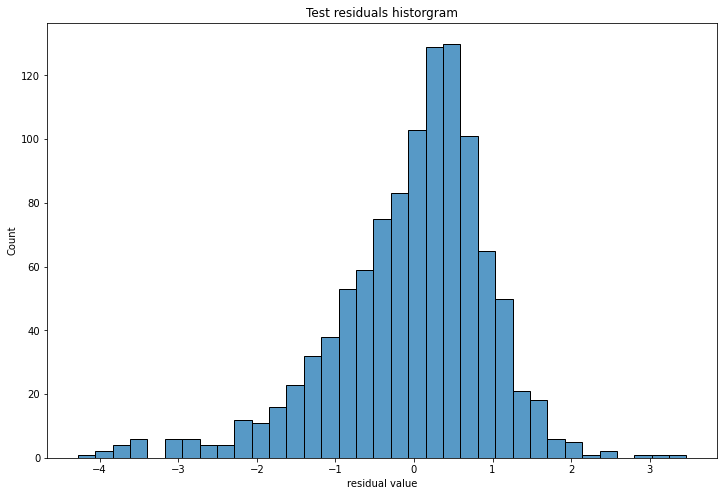

R^2 train score: 0.46381593117515696
R^2 test score: 0.2529627758185341
95% CI for P(score being off by more than 2 test set):
  [0.04115996 0.06735267]


In [28]:
# get X and Y
features_col_names = list(
    set(albums.columns.to_list()) - {"artist", "score", "album", "reviewauthor", "reviewdate",
                                     "recordlabel", "genre"}
)
task4_X = numpy_helper(albums, features_col_names)
task4_Y = numpy_helper(albums, "score")

# random split
train_split_ratio = 0.7
random_state = 123
task4_X_train, task4_X_test, task4_Y_train, task4_Y_test = train_test_split(
    task4_X,
    task4_Y,
    train_size=train_split_ratio,
    random_state=random_state
)

# gradient boosting regressor
gradient_boosting_regressor_album = GradientBoostingRegressor()
gradient_boosting_regressor_album.fit(task4_X_train, task4_Y_train)

task4_Y_train_pred_gbr = gradient_boosting_regressor_album.predict(task4_X_train)
task4_Y_test_pred_gbr = gradient_boosting_regressor_album.predict(task4_X_test)

fig, ax = plt.subplots(figsize=(12, 8))
plt.title("Test residuals historgram")
residuals = task4_Y_test - task4_Y_test_pred_gbr
sns.histplot(residuals, ax=ax)
plt.xlabel("residual value")
plt.show()

print(f"R^2 train score: {r2_score(task4_Y_train, task4_Y_train_pred_gbr)}")
print(f"R^2 test score: {r2_score(task4_Y_test, task4_Y_test_pred_gbr)}")
ci = percentile_bootstrap_ci(residuals, 5000, off_by_more_than_two_prob, seed=72, plot_boots=False)
print(f"95% CI for P(score being off by more than 2 test set):\n  {ci}")

### Task 4.3

In [29]:
def evaluate_gcr(x_train, y_train, x_test, y_test, learning_rate, n_estimators):
    gbr_album = GradientBoostingRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
    )
    gbr_album.fit(x_train, y_train)

    results = {
        "r2_train": r2_score(y_train, gbr_album.predict(x_train)),
        "r2_test": r2_score(y_test, gbr_album.predict(x_test))
    }
    return results


def build_k_indices(y, k_fold, np_seed=None):
    if np_seed is not None:
        np.random.seed(seed)

    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)


def cross_validation(y, x, k, n_estimators, learning_rate, np_seed=None):
    k_indices = build_k_indices(y, k, np_seed)
    r2_scores = []
    for current_fold in range(k):
        # split the data
        test_ind = k_indices[current_fold]
        train_ind = np.ones(x.shape[0], bool)
        train_ind[k_indices[current_fold]] = False

        y_valid = y[test_ind]
        y_train = y[train_ind]
        x_valid = x[test_ind]
        x_train = x[train_ind]

        r2_test_score = evaluate_gcr(x_train, y_train, x_valid, y_valid, learning_rate, n_estimators)["r2_test"]
        r2_scores.append(r2_test_score)

    return np.array(r2_scores)


def cv_model_selection(y, x, k, n_estimators_range, learning_rate_range, seed=None):
    best_mean, best_lr, best_n_estimators = None, None, None
    for e in n_estimators_range:
        for lr in learning_rate_range:
            r2_scores = cross_validation(y, x, N, e, lr, seed)
            r2_mean = r2_scores.mean()
            if best_mean is None or r2_mean > best_mean:
                best_mean = r2_mean
                best_lr, best_n_estimators = lr, e

            ci = percentile_bootstrap_ci(r2_scores, 5000, np.mean, confidence=90, seed=seed,
                                         plot_boots=False)
            print(f"n_estimator:{e}\tlearning_rate:{lr}\tmean r2:{r2_mean:.6f}\tmean r2 90-ci:{ci}")
            print(f"\tall_scores:{[f'{s:.4f}' for s in np.sort(r2_scores)]}\n")

    print(f"\nHighest CV mean of {best_mean:.6f}"
          f" achieved for model with n_estimators={best_n_estimators} and lr={best_lr}")
    results = {"best_mean": best_mean, "best_n_estimators": best_n_estimators, "best_lr": best_lr}
    return results

In [30]:
seed = 72
N = 20
n_estimators = [100, 200, 300, 400]
learning_rate = [0.1, 0.05, 0.01, 0.001]

results = cv_model_selection(task4_Y_train, task4_X_train, N, n_estimators, learning_rate, seed)
best_n_estimators = results["best_n_estimators"]
best_lr = results["best_lr"]

n_estimator:100	learning_rate:0.1	mean r2:0.145814	mean r2 90-ci:[0.10064583 0.18941839]
	all_scores:['-0.1637', '-0.0341', '-0.0132', '0.0681', '0.0833', '0.0975', '0.1005', '0.1236', '0.1409', '0.1437', '0.1547', '0.1669', '0.1894', '0.2024', '0.2131', '0.2369', '0.2508', '0.2527', '0.3318', '0.3711']

n_estimator:100	learning_rate:0.05	mean r2:0.168565	mean r2 90-ci:[0.12895433 0.20810273]
	all_scores:['-0.0769', '-0.0006', '0.0261', '0.1137', '0.1145', '0.1173', '0.1192', '0.1251', '0.1541', '0.1627', '0.1657', '0.2009', '0.2038', '0.2150', '0.2175', '0.2445', '0.2727', '0.2838', '0.3219', '0.3905']

n_estimator:100	learning_rate:0.01	mean r2:0.153406	mean r2 90-ci:[0.12996211 0.17736172]
	all_scores:['0.0244', '0.0670', '0.0785', '0.0953', '0.1082', '0.1132', '0.1147', '0.1221', '0.1403', '0.1416', '0.1609', '0.1763', '0.1772', '0.1837', '0.2030', '0.2060', '0.2079', '0.2134', '0.2284', '0.3059']

n_estimator:100	learning_rate:0.001	mean r2:0.024358	mean r2 90-ci:[0.01869008 0.029

In [31]:
test_results = evaluate_gcr(task4_X_train, task4_Y_train, task4_X_test, task4_Y_test, best_lr,
                            best_n_estimators)

print(f"R^2 train score: {test_results['r2_train']}")
print(f"R^2 test score: {test_results['r2_test']}")

R^2 train score: 0.3135621278137869
R^2 test score: 0.24646780786654932


### Task 4.4

The $R^2$ obtained with previous albums is much higher compared to the longitudinal split albums. However, the results are not comparable, for at least the following two reasons:

1. The train and test split fundamentally differs in that the previous album setup uses a random split that is indifferent to album release year. We have already discussed the negative impact of the score distribution shift over time that is accentuated by the longitudinal split made.
2. The setup with previous albums takes only the latest albums into account and of artists that published +2 albums. This will likely shift the distribution of the dataset.

To fairly correctly compare with vs without previous album information setups, one should make either both random or both longitudinal and work only with the latest albums. The only difference between the setups should be that one has information about previous albums and the other has none.

## Part 2: Second Album Syndrome

Your second project at *Piccardi Music* is to shed light on one of the business's oldest enigmas: the "second album syndrome." In a nutshell, the "second album syndrome" is a theory that states that the second album of a band always sucks. ([Related read](https://tvtropes.org/pmwiki/pmwiki.php/Main/SophomoreSlump))

Assume—for the purpose of this task—that the Pitchfork data contains all albums for all artists it covers (even though this might not be true in reality).

## Task 5 (Preliminary analyses — 8 pts)

You begin by carrying out some preliminary data processing and analyses.

1. Create a new dataframe (from the original data with duplicates dropped, the same as you obtained after finishing Task 1.1) containing only albums from artists with two or more albums and where the release year is not empty.
2. Create a new column `album_number` which indicates how many albums the artist has produced before this one (before the second album, the artist has already produced one album).
3. Calculate the mean and the standard error fo the mean of the scores of the first and second albums in the dataset. Additionally, plot the two distributions.
4. Use an appropriate method to determine if the difference in means of 1st and 2nd albums is statistically significant?
5. **Discuss:** Do these analyses suggest that the "second album syndrome" exists?

---

### Task 5.1

In [32]:
task5_df = pitchfork_df_after_task_1_1

artists = task5_df.groupby("artist").size()
artists = artists[artists.ge(2)]
print(artists.head())

task5_df = task5_df[task5_df["artist"].isin(artists.index)].sort_values(["artist", "releaseyear"],
                                                                        ascending=[True, False])
print(f"\nNumber of albums: {len(task5_df)}")
print(f"Number of albums with NaNs: {task5_df.isna().any(axis=1).sum()}")
print(f"Number of albums with NaN releaseyear: {task5_df.releaseyear.isna().sum()}")
print(f"\nreleaseyear.describe():\n{task5_df.releaseyear.describe()}")

task5_df.head(10)

artist
!!!                                              8
(Sandy) Alex G                                   2
...And You Will Know Us by the Trail of Dead    11
03 Greedo                                        4
13 & God                                         2
dtype: int64

Number of albums: 12410
Number of albums with NaNs: 0
Number of albums with NaN releaseyear: 0

releaseyear.describe():
count    12410.00
mean      2009.18
std          7.42
min       1957.00
25%       2005.00
50%       2010.00
75%       2014.00
max       2019.00
Name: releaseyear, dtype: float64


,artist,album,reviewauthor,score,releaseyear,reviewdate,recordlabel,genre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
16478,!!!,Wallop,Jesse Dorris,7.2,2019.0,2019-09-07,none,Rock,0.75,0.74,5.36,-8.63,0.13,9.86e-02,0.18,0.18,0.53,120.04
472,!!!,Shake the Shudder,Stuart Berman,7.3,2017.0,2017-05-24,Warp,Rock,0.71,0.77,4.75,-7.88,0.10,1.06e-01,0.21,0.25,0.69,122.01
14646,!!!,As If,Cameron Cook,6.9,2015.0,2015-10-21,Warp,Rock,0.79,0.77,5.73,-6.13,0.08,9.08e-02,0.11,0.12,0.66,122.09
2397,!!!,Thr!!!er,Brian Howe,6.0,2013.0,2013-04-30,Warp,Rock,0.78,0.80,5.67,-6.81,0.06,3.24e-02,0.08,0.16,0.81,117.91
10053,!!!,"Strange Weather, Isn't It?",Larry Fitzmaurice,6.9,2010.0,2010-08-20,Warp,Rock,0.71,0.88,4.56,-6.23,0.05,5.05e-02,0.24,0.24,0.76,117.53
10517,!!!,Myth Takes,Brian Howe,8.0,2007.0,2007-03-02,Warp,Rock,0.65,0.83,5.40,-6.94,0.07,9.20e-02,0.25,0.23,0.56,116.14
6891,!!!,Louden Up Now,Nick Sylvester,7.0,2004.0,2004-06-07,Touch and Go,Rock,0.81,0.75,6.82,-7.08,0.08,1.17e-01,0.40,0.16,0.69,119.97
7411,!!!,Split EP,Dominique Leone,6.0,1999.0,2004-02-12,GSL,Rock,0.47,0.91,6.00,-4.11,0.10,4.49e-04,0.00,0.18,0.60,97.05
16450,(Sandy) Alex G,House of Sugar,Anna Gaca,8.6,2019.0,2019-09-16,none,Rock,0.49,0.64,4.31,-5.60,0.03,2.55e-01,0.29,0.16,0.42,109.09
14343,(Sandy) Alex G,Rocket,Ian Cohen,8.4,2017.0,2017-05-19,Domino,Rock,0.46,0.59,6.07,-7.04,0.05,2.83e-01,0.31,0.22,0.46,128.36


There are no albums with empty `releaseyear`. Note that we did not drop albums with impossible, outlier values and did not preprocess missing values, as the instruction stressed to use task 1.1 dataframe.

### Task 5.2

For the albums that the same releaseyear (like Greedo's 2019 and 2018 albums), we arbitrarily assign which came first, the chicken or the egg.

In [33]:
task5_df["album_number"] = task5_df.groupby("artist").cumcount(ascending=False)
task5_df[task5_df.artist == "03 Greedo"]

,artist,album,reviewauthor,score,releaseyear,reviewdate,recordlabel,genre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,album_number
15531,03 Greedo,Still Summer in the Projects,Sheldon Pearce,7.6,2019.0,2019-04-24,Alamo,Rap,0.75,0.51,4.36,-6.20,0.11,0.19,0.00e+00,0.19,0.24,102.40,3
16226,03 Greedo,Netflix & Deal,Sheldon Pearce,7.5,2019.0,2019-12-05,none,Rap,0.83,0.54,4.54,-7.78,0.24,0.16,6.57e-04,0.20,0.57,133.93,2
11582,03 Greedo,The Wolf of Grape Street,Paul A. Thompson,8.0,2018.0,2018-03-15,Alamo,Rap,0.68,0.52,4.20,-9.57,0.21,0.07,1.80e-03,0.16,0.35,133.28,1
15027,03 Greedo,God Level,Torii MacAdams,8.0,2018.0,2018-07-05,Alamo,Rap,0.75,0.56,5.55,-8.10,0.17,0.15,9.24e-03,0.16,0.45,137.25,0


### Task 5.3

Number of 1st albums: 3564
Number of 2nd albums: 3564

Score:
1st album mean: 7.304040
1st album stddev: 1.236511
1st album stderr of the mean: 0.020712
2nd album mean: 7.034624
2nd album stddev: 1.268610
2nd album stderr of the mean: 0.021250


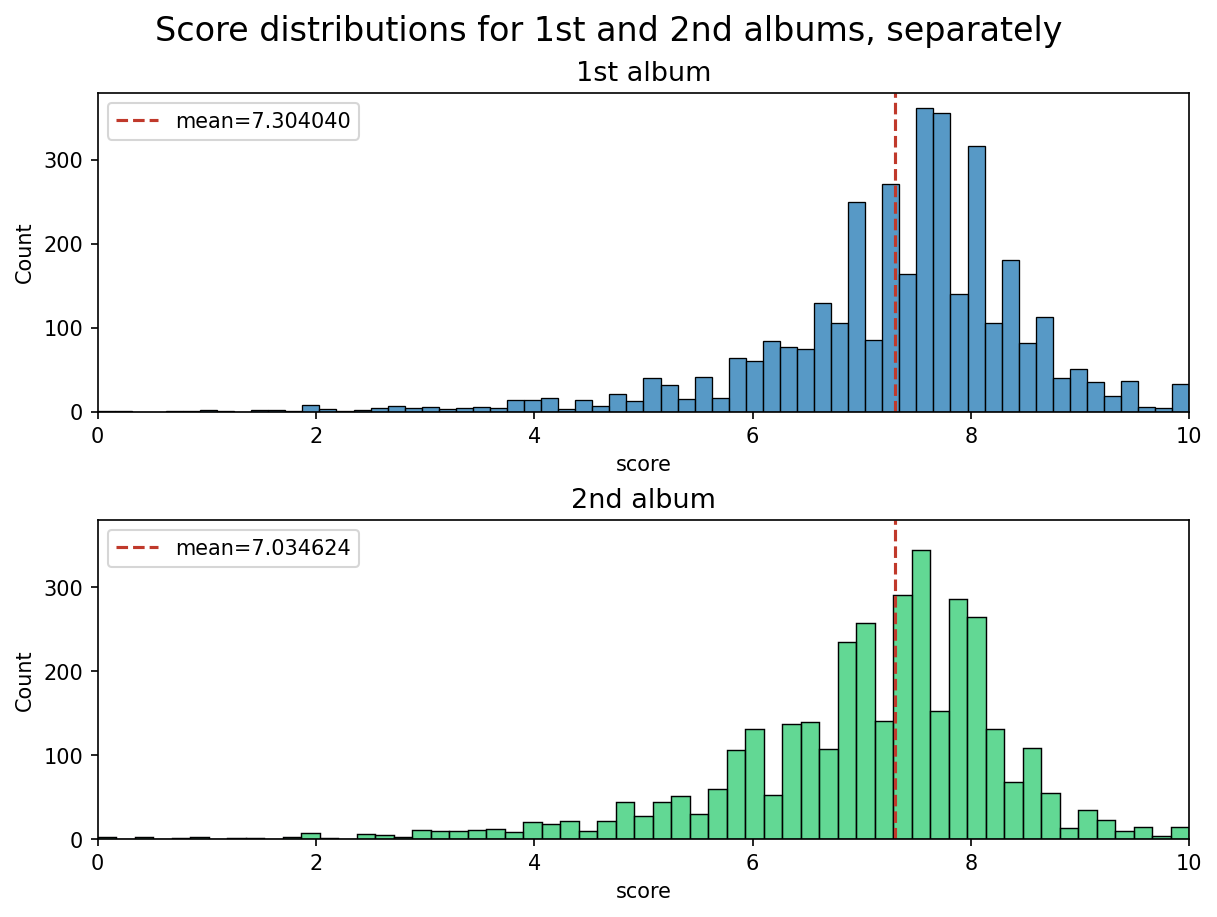

In [34]:
first_alb = task5_df[task5_df["album_number"] == 0]
second_alb = task5_df[task5_df["album_number"] == 1]
print(f"Number of 1st albums: {len(first_alb)}")
print(f"Number of 2nd albums: {len(second_alb)}")

first_mean = first_alb.score.mean()
second_mean = second_alb.score.mean()
print(f"\nScore:")
print(f"1st album mean: {first_mean:.6f}")
print(f"1st album stddev: {first_alb.score.std():.6f}")
print(f"1st album stderr of the mean: {first_alb.score.sem():.6f}")
print(f"2nd album mean: {second_mean:.6f}")
print(f"2nd album stddev: {second_alb.score.std():.6f}")
print(f"2nd album stderr of the mean: {second_alb.score.sem():.6f}")

fig, (ax1, ax2) = plt.subplots(2, 1, sharey="all", constrained_layout=True, figsize=(8, 6), dpi=150)
fig.suptitle("Score distributions for 1st and 2nd albums, separately", fontsize=16)

ax1.set_title("1st album", fontsize=13)
sns.histplot(first_alb.score, ax=ax1)
ax1.axvline(x=first_mean, color='#c0392b', linestyle='--', label=f"mean={first_mean:.6f}")
ax1.set_xlabel("score")
ax1.set_xlim(0, 10)
ax1.legend()

ax2.set_title("2nd album", fontsize=13)
sns.histplot(second_alb.score, color="#2ecc71", ax=ax2)
ax2.axvline(x=first_mean, color='#c0392b', linestyle='--', label=f"mean={second_mean:.6f}")
ax2.set_xlabel("score")
ax2.set_xlim(0, 10)
ax2.legend()

plt.show()

### Task 5.4

#### T-test

The `ttest_ind` calculates the T-test for the means of **two independent** samples of scores. It is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances, which is reasonably true for our two samples, as the empirical standard deviations for the samples are $1.236949$ and $1.268589$ (and there is the guideline that the ratio of the variances should be between $0.5$ and $2$). The assumptions of the means following a normal distribution should be satisfied by the central limit theorem since we have a large sample of what we assume to be independent datapoints.

We will perform the test with a confidence level of $\alpha=0.001$

In [35]:
ttest_ind(first_alb.score, second_alb.score)

Ttest_indResult(statistic=9.079115916860786, pvalue=1.394683061270046e-19)

Given that the t-statistic corresponds to a very low p-value, 16 orders of magnitude smaller than $\alpha$, we conclude to have found significant evidence for the means not being equal.

#### Bootstrap Confidence Intervals

Further, for pedagogical purposes, we will perform a bootstrapped confidence interval test as well, again with the null hypothesis of the means being equal and with $\alpha=0.001$:

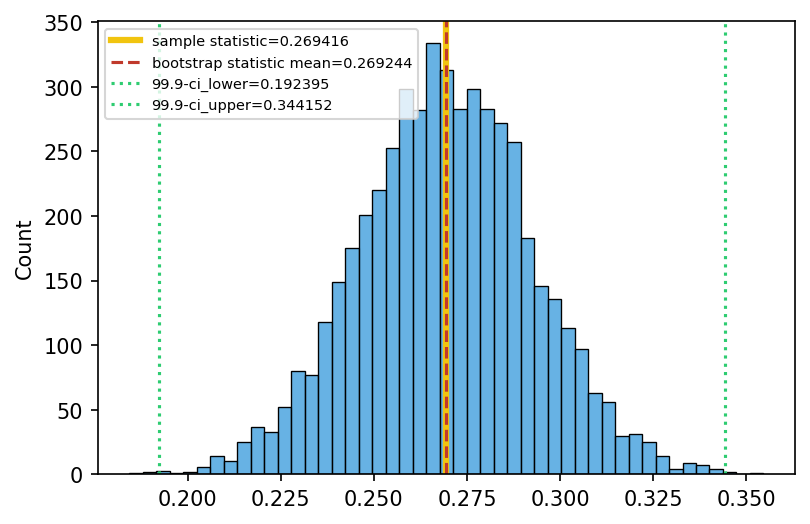

In [36]:
first_alb_scores_np = first_alb.score.to_numpy()
second_alb_scores_np = second_alb.score.to_numpy()

ci = percentile_bootstrap_ci(
    first_alb_scores_np - second_alb_scores_np,
    5000,
    lambda x: np.abs(x.mean()),
    confidence=99.9,
    plot_boots=True
)

We used the percentile method and all of its assumptions are justified - the bootstrapped samples are approximately symmetric and have a mean statistic value that almost matches the sample statistic.

Given that the null hypothesis is far outside the 99.9% confidence interval, we can reject it in favour of the mean score of the first album being higher than the mean score of the first album.

### Task 5.5

We have found significant evidence for the second album syndrome to exist in the Pitchfork reviews that we are working with, which might be a valid generalization if the Pitchfork reviews were not a highly biased sample of reviews, as discussed in task 1.

## Task 6 (Regression analysis — 20 pts)

Next, you proceed to examine some hypotheses about the "second album syndrome" using a regression framework. Namely:

- The **time spent hypothesis:**  the first album usually has a couple of years of development under its belt and plenty of trial and error from live concerts to help the band determine what does or doesn't work. The second album, on the other hand, is often made in a rush.

- The **style change hypothesis:** bands often try to change their style after their first album. This change is not always welcomed by the listeners.

1. Create a new dataframe containing one row per 1st-2nd album pair. The dataframe should contain rows:
    - `score_diff`: the difference in scores between the second and the first album (second - first).
    - `time_diff`: the number of days elapsed between the first and the second album.
    - `did_style_change`: a dummy variable that indicates whether the style of the music has changed. To obtain it, first, calculate the [standardized euclidean distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.seuclidean.html) of music-related numerical features¹ between the second and the first album. Second, assign 1 to the 20% most distant 1st-2nd album pairs and 0 to all others.
2. Fit a linear regression using `statsmodels` with this dataframe. Your regression should consider only an intercept, i.e., `"score_diff ~ 1"`.
3. **Discuss:** Interpret the $R^2$ in your regression here. Does this analysis confirm what you observed in Task 5? Why?
4. Include the `time_diff` and `did_style_change` as covariates in your model. Fit the regression again and report the summary of your model.
5. **Discuss:** Interpret the coefficients `time_diff` and `did_style_change`. Carefully explain whether they provide evidence towards each of the aforementioned hypotheses? Do they rule out other reasons that may cause the "second album syndrome effect"?
6. Create a new column called `time_diff_standardized`. It should be a standardized version of the `time_diff` column. Repeat the regression done in 6.4 using the `time_diff_standardized` column instead of the `time_diff` column.
7. **Discuss:** Explain how the interpretation of the coefficients associated with this new column `time_diff_standardized` differ from its non-standardized version
`time_diff`?

---

**¹** Music related numerical features are:  "key", "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "valence", and "tempo".


### Task 6.1

In [37]:
from scipy.spatial import distance

numerical_features = ["key", "acousticness", "danceability", "energy", "instrumentalness",
                      "liveness", "loudness",
                      "speechiness", "valence", "tempo"]

syndrome = pd.DataFrame()
syndrome["artist"] = first_alb.artist
syndrome["score_diff"] = second_alb.score.to_numpy() - first_alb.score.to_numpy()
syndrome["time_diff"] = (second_alb.releaseyear.to_numpy() - first_alb.releaseyear.to_numpy()) * 365

numerical_features_var = task5_df[task5_df.album_number.isin([0, 1])][
    numerical_features].var().to_numpy()
syndrome["distance"] = [
    distance.seuclidean(u, v, numerical_features_var)
    for u, v
    in zip(
        first_alb[numerical_features].to_numpy(),
        second_alb[numerical_features].to_numpy())
]
syndrome.sort_values("distance", ascending=False, inplace=True)
syndrome["did_style_change"] = np.concatenate([
    np.ones(int(len(syndrome) * 0.2)),
    np.zeros(len(syndrome) - int(len(syndrome) * 0.2))
])

syndrome.sort_values("artist", inplace=True)
syndrome.head(10)

,artist,score_diff,time_diff,distance,did_style_change
7411,!!!,1.0,1825.0,3.21,0.0
14343,(Sandy) Alex G,0.2,730.0,1.84,0.0
16287,...And You Will Know Us by the Trail of Dead,-0.1,730.0,2.76,0.0
15027,03 Greedo,0.0,0.0,1.32,0.0
3079,13 & God,-2.1,2190.0,2.61,0.0
14835,13ghosts,-0.2,1460.0,3.81,0.0
11338,1990s,-3.2,730.0,5.01,1.0
15948,2 Chainz,1.7,365.0,3.02,0.0
4903,21 Savage,-0.5,365.0,1.84,0.0
12221,2562,-0.8,730.0,3.44,0.0


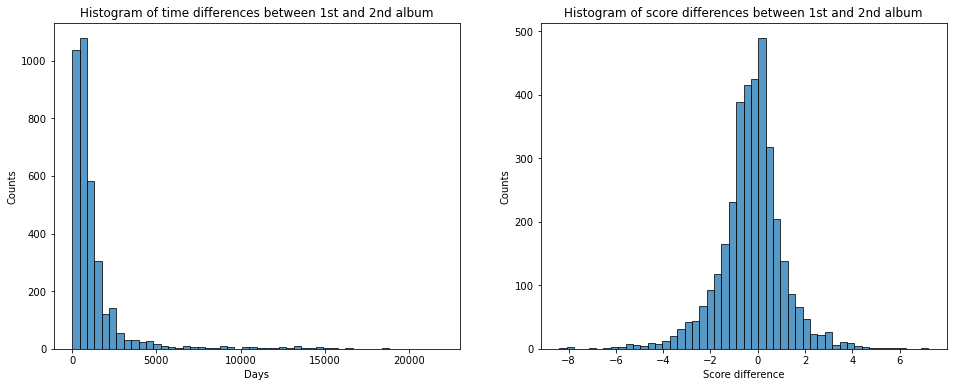

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(syndrome.time_diff, bins=50, ax=axs[0])
axs[0].set_title('Histogram of time differences between 1st and 2nd album')
axs[0].set_xlabel('Days')
axs[0].set_ylabel('Counts')
sns.histplot(syndrome.score_diff, bins=50, ax=axs[1])
axs[1].set_title('Histogram of score differences between 1st and 2nd album')
axs[1].set_xlabel('Score difference')
axs[1].set_ylabel('Counts')
plt.show()

### Task 6.2

In [39]:
model = smf.ols('score_diff ~ 1', data=syndrome)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             score_diff   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 26 Nov 2021   Prob (F-statistic):                nan
Time:                        22:20:26   Log-Likelihood:                -6202.3
No. Observations:                3564   AIC:                         1.241e+04
Df Residuals:                    3563   BIC:                         1.241e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2694      0.023    -11.662      0.0

### Task 6.3.

The $R^2$ value is zero which is expected as a constant model that always predicts the expected value of y, disregarding the input features, would get a $R^2$ score of 0.

The regression confirms the findings in task 5 that there is a significant difference between the mean scores of the first and second albums, as the p-value for the intercept is almost equal to zero. As the intercept is negative, the evidence suggests that the second album scores are lower.

### Task 6.4.

In [40]:
model = smf.ols('score_diff ~ time_diff + did_style_change', data=syndrome)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             score_diff   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     31.99
Date:                Fri, 26 Nov 2021   Prob (F-statistic):           1.71e-14
Time:                        22:20:26   Log-Likelihood:                -6170.6
No. Observations:                3564   AIC:                         1.235e+04
Df Residuals:                    3561   BIC:                         1.237e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.1464      0.029  

### Task 6.5.

The coefficient of $-0.0314$ for `did_style_change` indicates that for a change in the style (`did_style_change` goes from 0 to 1), we expected to see a decrease in the score difference (i.e. the second album scores get even worse compared to the first album, as the intercept is negative!), which is in line with the *style change hypothesis*. However, this coefficient is not significant at all as it achieved a p-value of 0.584 under the null hypothesis that `did_style_change` has no effect, which hinders us from abandoning the null hypothesis in favour of *style change hypothesis*.

For `time_diff`, on the other hand, we did find significant evidence for the coefficient not being zero, with a p-value close to zero. The coefficient equals a nutty $-8.97\times10^{-5}$, which means that spending 10000 days (cca 27 years) would give an expected decrease of $8.97$ in the score that the second album would have (as the intercept is negative). This gives us significant evidence to the contrary statement of the *time spent hypothesis* -- the more time is spent between the first and second album, the worse the second album would score on PitchFork reviews.

Even with this evidence, we cannot be sure that the conclusions hold ground since there might be confounders we are not aware of (but which can spoil the experiment), that is, other reasons which would explain the observed evidence for both the anti *time spent hypothesis* itself and the anti *time spent hypothesis* explaining the evident *second album syndrome*.

### Task 6.6.

In [41]:
time_diff_mean = syndrome['time_diff'].mean()
time_diff_std = syndrome['time_diff'].std()
print(f"Time diff mean: {time_diff_mean}")
print(f"Time diff std: {time_diff_std}")

syndrome['time_diff_standardized'] = (syndrome['time_diff'] - time_diff_mean) / time_diff_std
syndrome.head(10)

Time diff mean: 1312.730078563412
Time diff std: 2037.2397089849696


,artist,score_diff,time_diff,distance,did_style_change,time_diff_standardized
7411,!!!,1.0,1825.0,3.21,0.0,0.25
14343,(Sandy) Alex G,0.2,730.0,1.84,0.0,-0.29
16287,...And You Will Know Us by the Trail of Dead,-0.1,730.0,2.76,0.0,-0.29
15027,03 Greedo,0.0,0.0,1.32,0.0,-0.64
3079,13 & God,-2.1,2190.0,2.61,0.0,0.43
14835,13ghosts,-0.2,1460.0,3.81,0.0,0.07
11338,1990s,-3.2,730.0,5.01,1.0,-0.29
15948,2 Chainz,1.7,365.0,3.02,0.0,-0.47
4903,21 Savage,-0.5,365.0,1.84,0.0,-0.47
12221,2562,-0.8,730.0,3.44,0.0,-0.29


In [42]:
model = smf.ols('score_diff ~ time_diff_standardized + did_style_change', data=syndrome)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             score_diff   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     31.99
Date:                Fri, 26 Nov 2021   Prob (F-statistic):           1.71e-14
Time:                        22:20:26   Log-Likelihood:                -6170.6
No. Observations:                3564   AIC:                         1.235e+04
Df Residuals:                    3561   BIC:                         1.237e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

### Task 6.7.

First observe that the `did_style_change` coefficient and p-values did not change, as well as for the $R^2$ and $F$ statistics of the regression because we only performed a linear transformation. Only the intercept moved, as we have changed the mean of the former `time_diff` regressor, and the coefficient of `time_diff_standardized` is rescaled by the standard deviation of $2037.24$, that is: $-8.967\times10^{-5} * 2037.24 = -0.1827$, with $-0.1827$ being the new coefficient.

The new coefficient is interpreted as the change in the `score_diff` that is imposed by changing the `time_diff_standardized` by 1, aka by changing the `time_diff` by one standard deviation of $2038$ days (cca $5.5$ years).

## Task 7 (Sanity checks — 6 pts)**

You decide to perform a few last sanity checks for your analysis.

1.  **Discuss:** If the Second Album Syndrome existed, i.e., something was special about the second album (as in if it was bad for a very particular reason that afflicted album number 2 more than all others), what would you expect to happen to the mean score of the third album?
2. Using the dataset you created in Task 5, calculate the mean and the standard error of the mean for the 1st, 2nd, 3rd, and 4th albums. Test whether the difference between the average score of the second and the third album is statistically significant.
3. **Discuss:** Does this suggest that the Second Album Syndrome exists?

---


### Task 7.1

If the Second Album Syndrome existed where the second album is perceived considerably worse than the others, then we would expect the third album to have better results than the second album.

### Task 7.2

In [43]:
for i in range(4):
    print(f'Album {i + 1}:')
    album = task5_df[task5_df.album_number == i]
    print(f'   N: {len(album)}')
    print(f'   Mean score: {album.score.mean()}')
    print(f'   Stddev score: {album.score.std()}')
    print(f'   Stderr of score mean: {album.score.sem()}')

Album 1:
   N: 3564
   Mean score: 7.304040404040404
   Stddev score: 1.2365109190491683
   Stderr of score mean: 0.020712337210422274
Album 2:
   N: 3564
   Mean score: 7.034624017957352
   Stddev score: 1.2686097057461563
   Stderr of score mean: 0.021250012117995813
Album 3:
   N: 1950
   Mean score: 7.054205128205129
   Stddev score: 1.214839094964447
   Stderr of score mean: 0.02751068814818498
Album 4:
   N: 1178
   Mean score: 7.03981324278438
   Stddev score: 1.2445096958658073
   Stderr of score mean: 0.0362598196184704


To whether the difference between the average score of the second and the third album is statistically significant, we will perform a `ttest_ind` with a confidence level of $\alpha=0.001$. We can perform this test since N is large enough, the empirical variances are close one to another, and we will further assume that the samples are independent.

In [44]:
ttest_ind(task5_df[task5_df.album_number == 1]['score'],
          task5_df[task5_df.album_number == 2]['score'])
# ttest_ind(task5_df[task5_df.album_number == 1]['score'], task5_df[task5_df.album_number == 2]['score'], equal_var=False)

Ttest_indResult(statistic=-0.5561965452182934, pvalue=0.5780990778117756)

Given that the t-statistic corresponds to a very high p-value, we conclude not to have found evidence for the means being different.

### Task 7.3.

As the p-value is large, we cannot deny the null-hypothesis that the mean score of the second and third album are the same. This represents evidence against the *Second Album Syndrome* as it prophesied a score increase in the third album.

## Task 8 (Eureka — 14 pts)

Your boss, *Signor Piccardi*, proposes that you carry out a simulation to make things clearer. Assuming that:


- Each band $i$ has a "talent" $\mu_i$ , which is uniformally distributed between 2 and 8, i.e., $\mu_i \sim U_{[2,8]}$.
- When a band $i$ produces an album $j$, it has quality $s_j$. This score is normally distributed with mean $\mu_i$ and standard deviation $1$, i.e., $s_j \sim N(\mu_i, 1)$
- Talents are independent and identically distributed random variables.

Carry out the following simulation:

- Create 1000 hypothetical bands with intrinsic talents $\mu_i \sim U_{[2,8]}$ for $i \in [1,1000]$.
- Have each hypothetical band create a hypothetical album.
- Discard all bands whose albums received a score smaller than 6.
- For each of the remaining bands, create two additional albums.

Analyzing the scores obtained in this simulation, provide a coherent explanation for the  scores obtained in Task 7.2.

---

**Hint:** You can use numpy to sample random variables (e.g. [numpy.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html))

In [45]:
task8_df = pd.DataFrame()
seed = 42

# generate talents
rng = np.random.default_rng(seed)
task8_df['talent'] = (8 - 2) * rng.random((1000,)) + 2

# generate the first scores
task8_df['score_1'] = rng.normal(task8_df['talent'], 1)

#filter those bands who have at least 6
task8_df = task8_df[task8_df.score_1 >= 6]

# generate two more albums
for i in range(2):
    task8_df[f'score_{i + 2}'] = rng.normal(task8_df['talent'], 1)

task8_df.head()

,talent,score_1,score_2,score_3
2,7.15,7.19,7.06,6.88
5,7.85,8.08,7.42,8.27
6,6.57,7.18,7.36,7.82
11,7.56,6.14,7.32,8.70
12,5.86,6.31,5.56,5.87


Let's compare the random albums' scores with the ones obtained in Task 7.2 and check standard deviations of the random album scores.

In [46]:
for i in range(3):
    print(f'Album {i + 1}:')
    album = task5_df[task5_df.album_number == i]
    print(f'\tN: {len(album)}')
    print(f'\tMean score: {album.score.mean()}')
    print(f'\tStddev score: {album.score.std()}')
    print(f'\tStderr of score mean: {album.score.sem()}')

    print(f'Random Album {i + 1}:')
    scores = task8_df[f"score_{i + 1}"]
    print(f'\tN: {len(scores)}')
    print(f'\tMean score: {scores.mean()}')
    print(f'\tStddev score: {scores.std()}')
    print(f'\tStderr of score mean: {scores.sem()}', end='\n\n')

Album 1:
	N: 3564
	Mean score: 7.304040404040404
	Stddev score: 1.2365109190491683
	Stderr of score mean: 0.020712337210422274
Random Album 1:
	N: 352
	Mean score: 7.152782805671442
	Stddev score: 0.8510970601350972
	Stderr of score mean: 0.04536362572723919

Album 2:
	N: 3564
	Mean score: 7.034624017957352
	Stddev score: 1.2686097057461563
	Stderr of score mean: 0.021250012117995813
Random Album 2:
	N: 352
	Mean score: 6.712318759639836
	Stddev score: 1.3323111466297752
	Stderr of score mean: 0.0710124227175082

Album 3:
	N: 1950
	Mean score: 7.054205128205129
	Stddev score: 1.214839094964447
	Stderr of score mean: 0.02751068814818498
Random Album 3:
	N: 352
	Mean score: 6.7255900544102865
	Stddev score: 1.3677254050085923
	Stderr of score mean: 0.07290000903139982



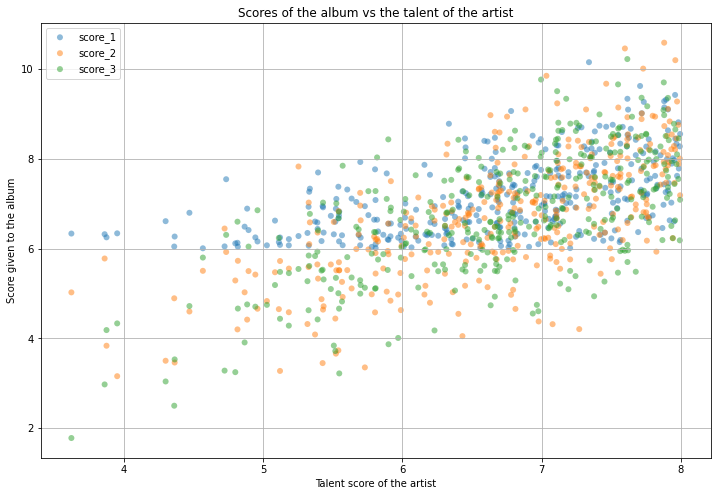

In [47]:
from matplotlib.pyplot import figure

#figure(figsize=(12, 8), dpi=80)
#fig = plt.scatter(task8_df['talent'], task8_df.score_1)
#plt.scatter(task8_df['talent'], task8_df.score_2)
#plt.scatter(task8_df['talent'], task8_df.score_3)

i = 0
fig, ax = plt.subplots(figsize=(12, 8))
for color in ['tab:blue', 'tab:orange', 'tab:green']:
    i += 1
    ax.scatter(task8_df['talent'], task8_df[f'score_{i}'], c=color, label=f'score_{i}',
               alpha=0.5, edgecolors='none')

ax.legend()
ax.grid(True)
ax.set_title('Scores of the album vs the talent of the artist')
ax.set_xlabel('Talent score of the artist')
ax.set_ylabel('Score given to the album')
plt.show()

To formally test the differences in means, as was done in the previous tasks, we will again perform `ttest_ind` tests after making sure that the t-test can be applied by printing the standard deviations of album scores and showing that they're not significantly different above.

In [48]:
print(f"`ttest_ind` for the mean scores of 1st and 2nd album being:")
print(ttest_ind(task8_df.score_1, task8_df.score_2))

print(f"\n`ttest_ind` for the mean scores of 2nd and 3rd album being:")
print(ttest_ind(task8_df.score_2, task8_df.score_3))

`ttest_ind` for the mean scores of 1st and 2nd album being:
Ttest_indResult(statistic=5.227117287015456, pvalue=2.2734630656488868e-07)

`ttest_ind` for the mean scores of 2nd and 3rd album being:
Ttest_indResult(statistic=-0.13040451487996152, pvalue=0.8962837530934273)


We can observe the same in this simulation. The means are similar in the 2nd and the 3rd albums, however the 1st albums' mean is substantially higher. Our hypothesis for the observed phenomena is that to get noticed, to get popular and reviewed, your first album needs to come through as good, otherwise nobody will cares for your album, you stop making music, and there are no reviews for you. After this initial high-pass filtering, you will likely get reviews and attention for your next albums, but now there is no lower-bound threshold. If you have "high talent", you will deliver good results, similar to the ones before, but if that is not the case, and you got the high first-album score because of luck, then your next albums will be in accord with your lower "talent". Thus, overall, it seems that the next albums have lower ratings.